# Preparation of job postings for analysis 

In this notebook, we'll be preparing data for analysis in a project focused on predicting salaries from job postings. We'll be working with a dataset of scraped job postings from Google Job search results. 

The goal of this notebook is to clean and transform the data so that it is ready for modeling and further analysis.

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# libraries used for tokenization
from itertools import chain
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize, MWETokenizer

# Libraries used to remove similar job description based on cosine similarity 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# libraries used for text normalization
import string

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist

# lemmatization w/ spacy
import spacy
from spacy.symbols import ORTH, LEMMA
from spacy import displacy

from wordcloud import WordCloud

# use to get USdollar / euro exchange rate from exchange rate API
import requests

import unicodedata


# import my customs functions
from preprocessing import preprocess as pp

## Load data

In [2]:
df = pd.read_csv('/home/axel/ds_projects/projects/gg_job_search/data/gg_job_search_all_RAW.csv')
data = df.copy()

data.head(5)

,Unnamed: 0,title,company_name,location,via,description,job_highlights,related_links,thumbnail,extensions,job_id,posted_at,schedule_type,date_time,search_query,Unnamed: 0.1
0,0,Data Scientist Lead H/F,Fifty-Five,Paris,via HelloWork,Fifty-Five recherche …\n\nDescription\nData Sc...,"[{'items': [""Fifty-Five recherche …\n\nDescrip...",[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 16 heures', 'À plein temps']",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBMZWFkIE...,il y a 16 heures,À plein temps,2023-02-17 11:50:44.355114,data engineer,NaN
1,1,DATA SCIENTIST (IT) / Freelance,Société Free-Work,Gennevilliers,via LinkedIn,Contexte : Dans le cadre de plusieurs projets ...,[{'items': ['Contexte : Dans le cadre de plusi...,[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 17 heures', 'À plein temps']",eyJqb2JfdGl0bGUiOiJEQVRBIFNDSUVOVElTVCAoSVQpIC...,il y a 17 heures,À plein temps,2023-02-17 11:50:44.355114,data engineer,NaN
2,2,Data analyst / Data scientist H/F,GrandVision France,Châtenay-Malabry,via Figaro Emploi,Quelles sont les missions ?\n\nVous\navez beso...,"[{'items': [""Quelles sont les missions ?\n\nVo...",[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 11 heures', 'À plein temps']",eyJqb2JfdGl0bGUiOiJEYXRhIGFuYWx5c3QgLyBEYXRhIH...,il y a 11 heures,À plein temps,2023-02-17 11:50:44.355114,data engineer,NaN
3,3,Data Scientist H/F,Consept Informatique,Nantes,via HelloWork,Consept Informatique recherche …\n\nIntégré(e)...,"[{'items': [""Consept Informatique recherche …\...",[{'link': 'https://www.google.fr/search?gl=fr&...,NaN,"['il y a 11 heures', '35\xa0k\xa0€ à 40\xa0k\x...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBIL0YiLC...,il y a 11 heures,À plein temps,2023-02-17 11:50:44.355114,data engineer,NaN
4,4,Data Scientist - Industrial Field,Fieldbox,Bordeaux,via LinkedIn,"As part of the Data Science team, you work clo...","[{'items': ['As part of the Data Science team,...",[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 19 heures', 'À plein temps']",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCAtIEluZH...,il y a 19 heures,À plein temps,2023-02-17 11:50:44.355114,data engineer,NaN


## General overview of data

In [3]:
print(data.info(), '\n')
print('='*70, '\n'*2, 'Number of unique values : ', '\n'*2,data.nunique(), '\n'*2)
print('='*70, '\n'*2,'Search query results :', '\n'*2, data.search_query.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29354 entries, 0 to 29353
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      29354 non-null  int64  
 1   title           29351 non-null  object 
 2   company_name    29351 non-null  object 
 3   location        29304 non-null  object 
 4   via             29354 non-null  object 
 5   description     29291 non-null  object 
 6   job_highlights  23018 non-null  object 
 7   related_links   29265 non-null  object 
 8   thumbnail       25258 non-null  object 
 9   extensions      29354 non-null  object 
 10  job_id          26181 non-null  object 
 11  posted_at       27214 non-null  object 
 12  schedule_type   29074 non-null  object 
 13  date_time       29354 non-null  object 
 14  search_query    29354 non-null  object 
 15  Unnamed: 0.1    6333 non-null   float64
dtypes: float64(1), int64(1), object(14)
memory usage: 3.6+ MB
None 


 Number of

### Checking for null values 

In [4]:
data.isnull().sum()[data.isnull().sum() > 0]

title                 3
company_name          3
location             50
description          63
job_highlights     6336
related_links        89
thumbnail          4096
job_id             3173
posted_at          2140
schedule_type       280
Unnamed: 0.1      23021
dtype: int64

In [5]:
data.fillna('unknown' , inplace=True)

### Removing duplicates

In [6]:
print('Number of duplicates :',data[data.duplicated()].shape[0])
print('Number of duplicates (based on identical job_id) :', data[data.duplicated(['job_id'])].shape[0],'\n', '='*70) 

# removing duplicates based on job_id and description
data.drop_duplicates(['description'], inplace=True)
data.drop_duplicates(['job_id'], inplace=True)
data.reset_index(inplace=True)

print('Search query results :\n', data.search_query.value_counts(), '\n', '='*70)
print('Final number of rows : ', data.shape[0])
print('Final number of columns : ', data.shape[1])

Number of duplicates : 546
Number of duplicates (based on identical job_id) : 22062 
Search query results :
 data scientist               2462
data analyst                 1324
data engineer                1176
machine learning engineer     398
data scientist jobs            87
Name: search_query, dtype: int64 
Final number of rows :  5447
Final number of columns :  17


Purely based job id, we can skim off a lots of duplicates. Nonetheless i still found a few of identical / near-identical job descriptions, maybe because [sometimes recruiters or companies post the same advert for a job which results in duplicate data.](https://medium.com/analytics-vidhya/data-science-job-search-using-nlp-and-lda-in-python-12ecbfac79f9)

To get rid off these ones, i will use cosine similatity between job descriptions.

### Removing remaining duplicates w/ Cosine Similarity

There are several methods to consider to identify the remaining job postings not captured. We could group them in 3 :

    * Fuzzy mathing methods
    * Clustering methods
    * Topic modeling methods
 
Fuzzy matching methods can be a better choice for identifying job postings with minor variations because it can account for small spelling mistakes, typos and slight variations in the wording or phrasing of the job description. 

So i will go with cosine similarity which is a measure of the similarity between two non-zero vectors in a high-dimensional space, and is commonly used for comparing text documents


### removing duplicates based on cosine similarity between 
## job descriptions (code from Thomas Caffrey, see link above)

# Defining our collection of job description texts to tokenize
data.description = data['description'].fillna('')
corpus = data['description']

# instantiate CountVectorizer object
count_vect = CountVectorizer()

# Fit_transform to vectorize each job description (map terms to feature indices)
X_train_counts = count_vect.fit_transform(corpus)

# Compute cosine similarities and put it in dataframe
cos_df = pd.DataFrame(cosine_similarity(X_train_counts))


## reshape dataframe for easier comparison

# get arrays of rows indices and col indices from col_df.shape
i, j = np.indices(cos_df.shape).reshape(2,-1)

# reshape values to get a 1D array 
cos_values = cos_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'sim':cos_values})

# get cosine similarity values only above 0.98 
cos_rem = cos_sim_df[(cos_sim_df['sim'] > 0.90) & (i!=j)]

# Method to remove duplicates but keep first instance:
# Trying to drop duplicates on i and j columns won't work as the row numbers of duplicates are either in i or j not both.
# Setting another column that combines the i & j values ensures that duplicates can be dropped.

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates('i*j')['i'].values)

# keep only non-duplicated job postings
data = data[~data.index.isin(drop_rows)] 
data.reset_index(inplace=True)

print('Search query results :\n', data.search_query.value_counts(), '\n', '='*70)
print('Number of duplicates (based on cosine similarity) : ' ,drop_rows.shape[0])
print('Final number of rows : ', data.shape[0])
print('Final number of columns : ', data.shape[1])

#### INSIGHTS :

Based on this sample of job titles, we could create : 
    
    * Contract_type (full-time, part-time ...) 
    * Contract_status (CDI, CDD, work-study, internship ...)
    * Duration of Contract (Duration/Undetermined)
    * Experience ( Senior, Junior ...)
    * Data Specialization (Supply chain, Marketing, Clinical ...)
    * Multiple titles (Analyst/Scientist, Scientist/ML Engineer, Manager/Analyst ...)
    * Specific expertise asked for (Python, Power BI ...)
    
    

## Explore company_name

In [7]:
print('number of unique companies :', data.company_name.nunique())
#data.company_name.unique()

number of unique companies : 2249


In [8]:
#data.loc[data['company_name'] == 'Unspecified', ['description']].iloc[0]

#### INSIGHTS :

When ***Unspecified***, companies name can be found in description column.

Possible new columns :

    * Group/Holding (Y/N/NC)
    * Interim company (Y/N/NC)

Based on the number of job posting per company we could potentially infer about : **size of company ? / Amount of data to work on** / 

Adding a time variable and much more data, the number of similar / identical job postings for the same company could maybe give insights on the **company's turnover rate / company's growth / magnitude of need-urgency to hire** ...  

It seems like extracting additional informations without more context will be difficult. Having access to each company's structure information we could create :

    * Size of company
    * Industry
    * Public / Private
    
We'll see if can extract more related informations in the following columns. Otherwise, we could try to scrap **Glassdoor databases** (or similar) to get those informations.remains to be seen ...

## Explore location

In [9]:
print('number of unique locations : ', data.location.nunique())
#data.location.unique()

number of unique locations :  494


In [10]:
#data.location.value_counts().head(20)

#### INSIGHTS :

We could create a map of th repartition of job posting based on location provided.

Some companies don't provide precise location *(ex : location = FRANCE)* and the information is not available in description column either. Further investigations will be needed for these companies, perhaps in conjunction with other databases *(GLASSDOOR / SIRENE databases for instance)*.

## Explore via

In [11]:
print('number of unique job plateforms : ', data.via.nunique())
# data.via.unique()

number of unique job plateforms :  227


## Explore description

count     5447.000000
mean      3046.172388
std       1647.632778
min          7.000000
25%       1858.500000
50%       2822.000000
75%       3995.500000
max      14172.000000
Name: description, dtype: float64


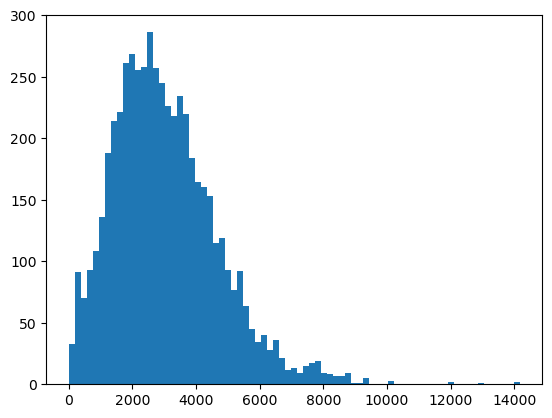

In [12]:
print(data.description.str.len().describe())

plt.hist(data.description.str.len(), bins=75)
plt.show()

#### INSIGHTS :


We could create :

    * Lenght of description (dunno what informations it could provide yet)
    * Toold required (Excel, Google Tag Manager ...)
    * Coding languages required (R, Python, SQL ...)
    * Skills required (reporting, data visualization)
    * Required experience
    * Duration of contract
    * Avantages (ticket resto)


data["all_bullets_string"] = [' '.join(map(str, re.findall('•(.+)',data.description[i]))) for i, _ in enumerate(data.description)]

## Quick text processing

Before creating new features and extractings keywords i'm going to do some simple text normalization for easier parsing and processing : lower cases, remove accents and useless columns.

In [13]:
# removing useless columns
def drop_useless_cols(df, cols):
    df.drop(columns=cols, inplace=True)
    return df

cols_to_remove = ['index', 'Unnamed: 0', 'Unnamed: 0.1', 'related_links', 'job_id', 'posted_at', 'thumbnail', 'job_highlights']

data = drop_useless_cols(data, cols_to_remove)

# lowering cases
data = data.applymap(lambda x: x.lower() if type(x) == str else x )

# removing accents
def remove_accents(text):
    normalized = unicodedata.normalize('NFKD', text)
    without_accents = [c for c in normalized if not unicodedata.combining(c)]
    return ''.join(without_accents)

# get columns to remove accents
object_cols = set(data.select_dtypes(include='O').columns)
accents_keeped_cols = {'extensions'} # i already worked on extensions before, don't wanna remake my code ...
accents_removed_cols = list(object_cols - accents_keeped_cols)

data[accents_removed_cols] = data[accents_removed_cols].applymap(lambda x: remove_accents(x))

In [14]:
data.description[9]

"a propos d'alstef group ?\n\ngroupe international en pleine croissance, alstef group concoit, integre et maintient des solutions automatisees pour l'amelioration des performances des processus logistiques.\n\nnotre mission : creer des solutions intelligentes qui, au-dela de repondre aux besoins de nos clients, leur font beneficier durablement d’un systeme automatise sur-mesure performant, evolutif et innovant.\n\nnos activites\n\nnous proposons aux aeroports du monde entier des solutions completes et innovantes pour le traitement des bagages de soute.\n\nnous offrons egalement des solutions de manutention integrees completes qui s’etendent des chariots automatiques aux entrepots entierement automatises.\n\nen quelques chiffres alstef group, c’est\n• 165 m€ de chiffre d’affaires\n• 800 collaborateurs\n• 13 filiales a l’etranger\n• 26% des salaries actionnaires du groupe\n\net si vous commenciez une nouvelle aventure avec alstef group ?\n\nvos missions ?\n\nau cours de cette alternance,

## Extracting features from job titles & job descriptions

As keywords meaning in job descriptions tends to vary a lot more depending on context, i will only extract employment-related kw from it (after investigations employment kws seem to be quite constant in their meaning even in job descriptions).

For example, senerioty level keywords contained in job titles are pretty straightforward in term of meaning (employer looking for a specific seniority level) but in job descriptions the same keyword could explain that "as a junior data analyst you will be supervised by several senior data analyst". 

To avoid extracting meaningless keywords i will leave aside job descriptions for now. It'll require fancier extracting methods.

In [15]:
def create_employment_type(row):
    employment_type_dict = {
        'CDI': {'cdi'},
        'internship': {'stage', 'internship', 'stagiaire'},
        'apprenticeship': {'alternant', "contrat d'apprentissage", 'contrat de professionnalisation', 'alternance',
                           "(apprenti)", "en apprentissage"},
        'CDD': {'cdd'},
        'freelance': {'freelance', 'prestataire', 'freelancer'},
        'interim': {'poste en Intérim'}
}
    for employment_type, keywords in employment_type_dict.items():
        regex = re.compile(r'\b(?:%s)\b' % '|'.join(keywords), re.I)
        if regex.search(row['title']) or regex.search(row['description']):
            return employment_type
    return np.nan

def create_seniority_level(row):
    seniority_level_dict = {
        'senior': {'senior', 'advanced', 'avance', 'sr', 'experimente'},
        'mid-level': {'confirme'},
        'junior': {'junior', 'debutant', 'jr', 'entry-level'},
}
    
    for seniority_level, keywords in seniority_level_dict.items():
        regex = re.compile(r'\b(?:%s)\b' % '|'.join(keywords), re.I)
        if regex.search(row['title']):
                return seniority_level
    return np.nan

def create_executive_title(row):
    executive_title_dict = {
        'lead': {'lead'},
        'Director': {'director', 'directeur'},
        'Manager': {'manager', 'project manager', 'chef de projet'},
        'Assistant': {'assistant'},
        'Chief': {'chief'},
        'Head': {'head'},
        'Supervisor': {'supervisor'},
}
    for executive_title, keywords in executive_title_dict.items():
        regex = re.compile(r'\b(?:%s)\b' % '|'.join(keywords), re.I)
        if regex.search(row['title']):
            return executive_title
    return np.nan

def create_remote_availability(row):
    remote_availability_dict = {
        'full': {'100 % teletravail', 'remote role', 'full remote', 'teletravail complet', 'fully remote', 
                 'full-time remote', "l'entreprise fonctionne en remote", 'full tt' },
        'partial_remote': {'teletravail/semaine', 'teletravail possible', 'jours / mois', '(2j / semaine)', 
                           'teletravail de','teletravail hybride', 'jours de teletravail','teletravail\n\npartiel',
                           'teletravail partiel', 'jour de teletravail', 'teletravail par semaine', 'format hybride',
                          'jour par semaine', 'jours par semaine', 'j de TT', 'j TT', 'j par semaine', 'jours de tt', 'jours de remote',
                          'jour de remote'}
}
    for remote, keywords in remote_availability_dict.items():
        regex = re.compile(r'(?:%s)' % '|'.join(keywords), re.I)
        if regex.search(row['title']) or regex.search(row['description']):
              return remote
    return np.NaN

data['employment_type'] = data.apply(create_employment_type, axis=1) 
data['seniority_level'] = data.apply(create_seniority_level, axis=1)
data['executive_title'] = data.apply(create_executive_title, axis=1)
data['remote_availability'] = data.apply(create_remote_availability, axis=1)


## Extracting and preprocessing salaries

In [26]:
def get_salary_col(df):
    
    # Extract salary from extensions col
    df['extracted_salary'] = pd.Series(df.extensions.str.split(', ', expand=True)[1])
       
    # Replace non-salary values to np.NaN
    df['extracted_salary'].replace(["'à plein temps']", "'à temps partiel']", "'stage']", "'prestataire']"], np.NaN, inplace=True)
    
    # Convert null values to Nothing_found to make parsing easier
    df.at[df.extracted_salary.isnull(), 'extracted_salary'] = "nothing_found"
    
    return df


def get_og_salary_currency(df):
    df['og_salary_currency'] = df.extracted_salary.str.extract(r'(\€|\$us)', flags=re.IGNORECASE)
    
    return df


def get_og_salary_period(df):
    df['og_salary_period'] = df.extracted_salary.str.extract(r'(\ban\b|\bmois\b|\bjour\b)', flags=re.IGNORECASE)
    
    return df
    

def clean_salary(df):
    
    
        ####### targeted clean for easier parsing #######

        for index, salary_str in enumerate(df.extracted_salary):
                
                if 'nothing_found' not in salary_str:
                    
                    # split salary period from rest of string
                    salary_str =  salary_str.split(' par')[0]
                    
                    # remove single quote
                    salary_str = salary_str.split("'")[1]

                    # remove unicode chars
                    salary_str = salary_str.replace("\\xa0", "")
                    salary_str = salary_str.replace("\\u202f", "")

                    #remove currency
                    salary_str = salary_str.replace("€", "")
                    salary_str = salary_str.replace("$us", "")
                    salary_str = salary_str.replace("$US", "")

                    df.at[index, 'extracted_salary'] = salary_str
                    
        return df

def get_salary_range_and_mean(df):                    
                 
                                        
        for index, row in df.iterrows():
    
            # extract boundaries of YEAR salaries given as a range + calculate mean salary
            if (row['og_salary_period'] == 'an') and 'à' in row['extracted_salary']:

                # remove k 
                row['extracted_salary'] = row['extracted_salary'].replace('k', '000')

                # get upper and lower bounds
                lower_bound = float(row.extracted_salary.split(' à ')[0].split(',')[0])
                upper_bound = float(row.extracted_salary.split(' à ')[1].split(',')[0])

                # re-establish a consistent value regarding to common year salaries
                if lower_bound < 200:
                    lower_bound = lower_bound * 1000
                    
                elif lower_bound > 200 and lower_bound < 1000 :
                    lower_bound = lower_bound * 100
                    
                if upper_bound < 200:
                    upper_bound = upper_bound * 1000
                    
                if upper_bound < 200 and upper_bound < 1000:
                    upper_bound = upper_bound * 100
                
                # get upper / lower bound and discrete_salary columns
                df.at[index, 'lower_bound'] = lower_bound
                df.at[index, 'upper_bound'] = upper_bound
                df.at[index, 'discrete_salary'] = np.mean([lower_bound, upper_bound])
                
                
                
            

            # extract discrete YEAR salaries        
            elif (row['og_salary_period'] == 'an') and 'à' not in row['extracted_salary']:

                # remove k
                row['extracted_salary'] = row['extracted_salary'].replace('k', '000')
                row['extracted_salary'] = row['extracted_salary'].replace(',', '.')

                # convert value to float
                row['extracted_salary'] = float(row['extracted_salary'])

                # re-establish a consistent value regarding to common year salaries
                if row['extracted_salary'] < 1000:
                    row['extracted_salary'] = row['extracted_salary'] * 1000

                # assign result to discrete salary column
                df.at[index, 'discrete_salary'] = row['extracted_salary']

                

            
            # extract boundaries of MONTH salaries given as a range + calculate mean salary   
            elif (row['og_salary_period'] == 'mois') and 'à' in row['extracted_salary']:

                # remove k and replace commas
                row['extracted_salary'] = row['extracted_salary'].replace('k', '00')
                row['extracted_salary'] = row['extracted_salary'].replace(',', '.')

                # get upper and lower bounds
                lower_bound = float(row.extracted_salary.split(' à ')[0])
                upper_bound = float(row.extracted_salary.split(' à ')[1])

                # re-establish a consistent value regarding to common month salaries
                if lower_bound < 10:
                    lower_bound = lower_bound * 100

                if lower_bound < 1000:
                    lower_bound = lower_bound * 10

                if upper_bound < 10:
                    upper_bound = upper_bound * 100

                if upper_bound < 1000:
                    upper_bound = upper_bound * 10

                # get upper / lower bound and discrete_salary columns
                df.at[index, 'lower_bound'] = lower_bound
                df.at[index, 'upper_bound'] = upper_bound
                df.at[index, 'discrete_salary'] = np.mean([lower_bound, upper_bound])

                


            # extract discrete MONTH salaries        
            elif (row['og_salary_period'] == 'mois') and 'à' not in row['extracted_salary']:

                # remove k and replace commas
                row['extracted_salary'] = row['extracted_salary'].replace('k', '00')
                row['extracted_salary'] = row['extracted_salary'].replace(',', '.')

                # convert value to float
                row['extracted_salary'] = float(row['extracted_salary'])


                # re-establish a consistent value regarding to common year salaries 
                if row['extracted_salary'] < 1000 and type(row['employment_type']) == str and row['employment_type'] not in ['internship', 'apprenticeship']:
                    row['extracted_salary'] = row['extracted_salary'] * 1000
                 
                elif row['extracted_salary'] < 100:
                    row['extracted_salary'] = row['extracted_salary'] * 1000
            
                elif row['extracted_salary'] < 1000 and type(row['employment_type']) == str and row['employment_type'] in ['internship', 'apprenticeship']:
                    row['extracted_salary'] = row['extracted_salary']
                
                # assign result to discrete salary column
                df.at[index, 'discrete_salary'] = row['extracted_salary']
            
            # extract boundaries of DAY salaries given as a range + calculate mean salary   
            elif (row['og_salary_period'] == 'jour') and 'à' in row['extracted_salary']:
                
                # get upper and lower bounds
                lower_bound = float(row.extracted_salary.split(' à ')[0])
                upper_bound = float(row.extracted_salary.split(' à ')[1])

                # get upper / lower bound and discrete_salary columns
                df.at[index, 'lower_bound'] = lower_bound
                df.at[index, 'upper_bound'] = upper_bound
                df.at[index, 'discrete_salary'] = np.mean([lower_bound, upper_bound])
                    
                    
        return df
    
            
 # Define a global variable to cache the exchange rate value
cached_exchange_rate = None

# Define a function to get the exchange rate value
def get_exchange_rate():
    # Declare the variable as global to modify its value in the function
    global cached_exchange_rate
    
    try:
        # Send a network request to get the exchange rate
        response = requests.get('https://openexchangerates.org/api/latest.json?app_id=4820391575d04bdd8d07b7e15fb0a463')
        response.raise_for_status()
        
        # Parse the response and calculate the exchange rate
        data = response.json()
        exchange_rate = data['rates']['EUR'] / data['rates']['USD']
        
        # Cache the exchange rate value
        cached_exchange_rate = exchange_rate
        
    except (requests.exceptions.RequestException, json.decoder.JSONDecodeError) as e:
        # Handle any exceptions that occur during the API request
        # If the API request fails, use the cached exchange rate value if it exists
        if cached_exchange_rate is not None:
            exchange_rate = cached_exchange_rate
        else:
            # If there is no cached exchange rate value, raise the original exception
            raise e
    
    return exchange_rate           
            
# This function converts salary values in US dollars to euro currency
def convert_salary_currency(df):
    
    # Create a boolean mask to select rows where salary is in US dollars
    mask = df['og_salary_currency'] == '$us'   
    
    # Multiply the 'discrete_salary' column by the exchange rate
    df.loc[mask,'discrete_salary'] *= get_exchange_rate()
    
    # Return the modified dataframe
    return df


# This function converts salary values from their original period to yearly, monthly, and daily rates
def convert_salary_period(df):
    
    # Define constants used in the conversion calculations
    n_days_per_year = 250
    n_days_per_month = 20
        
    # Create a boolean mask to select rows where salary is reported annually
    mask = df['og_salary_period'] == 'an'

    # Convert the 'discrete_salary' values in the selected rows to yearly, monthly, and daily rates
    df.loc[mask, 'year_salary'] = df.loc[mask,'discrete_salary']
    df.loc[mask, 'month_salary'] = df.loc[mask,'discrete_salary'] / 12
    df.loc[mask, 'day_salary'] = df.loc[mask,'discrete_salary'] / n_days_per_year

    # Create a boolean mask to select rows where salary is reported monthly
    mask = df['og_salary_period'] == 'mois'

    # Convert the 'discrete_salary' values in the selected rows to yearly, monthly, and daily rates
    df.loc[mask, 'year_salary'] = df.loc[mask,'discrete_salary'] * 12
    df.loc[mask, 'month_salary'] = df.loc[mask,'discrete_salary'] 
    df.loc[mask, 'day_salary'] = df.loc[mask,'discrete_salary'] / n_days_per_month

    # Create a boolean mask to select rows where salary is reported daily
    mask = df['og_salary_period'] == 'jour'

    # Convert the 'discrete_salary' values in the selected rows to yearly, monthly, and daily rates
    df.loc[mask, 'year_salary'] = df.loc[mask,'discrete_salary'] * n_days_per_year
    df.loc[mask, 'month_salary'] = df.loc[mask,'discrete_salary'] * n_days_per_month
    df.loc[mask, 'day_salary'] = df.loc[mask,'discrete_salary'] 

    # Return the modified dataframe
    return df
    
def salary_prepro(df):
    
    df = get_salary_col(df)
    df = get_og_salary_period(df)
    df = get_og_salary_currency(df)
    df = clean_salary(df)
    df = get_salary_range_and_mean(df)
    df = convert_salary_period(df)
    df = convert_salary_currency(df)
    
    return df

data = salary_prepro(data)

In [30]:
mask = data.year_salary.notnull()
data.loc[mask, ['extracted_salary', 'og_salary_period', 'discrete_salary', 'lower_bound', 'upper_bound', 'year_salary']]['year_salary'].describe()

count       209.000000
mean      58045.369378
std       31399.376220
min        7200.000000
25%       40000.000000
50%       50000.000000
75%       66000.000000
max      157500.000000
Name: year_salary, dtype: float64

In [18]:
fzg= f

NameError: name 'f' is not defined

## Finding remaining salaries hidden in job descriptions

After thorough research, some salaries are not mentionned in extensions column but in the job descriptions one. Problem is that the salary information comes in many forms, hence the difficulty to extract it. To get a better sense of the many forms it can take i will extract n number of characters before and after a proxy keyword ('salaire').

As per i hope to get the full sentence in which the salary information is for each description containing the proxy keyword.

In [31]:
# defining constants
keywords = ['salaire', 'remuneration']#, 'durée', 'stage', 'contrat', 'localisation|lieu|location', 'statut', 'formation', 'profil', 
            #'mission', 'avantage', 'experience', 'soft', 'langue']
n_chars_after = 200
m_chars_before = 150
#col_name = f'charsss_around_{kw}'

# loop over keywords list
for kw in keywords:
    
    # define our new columns
    data[f'chars_around_{kw}'] = 'NC '

    # loop over each string in data.description
    for i, text in zip(data.index, data['description']):
        
        # get iterator over all keywords matches in each string
        search_obj = re.finditer(kw, text, re.I)

        if search_obj: # ... is true, then ...

            # get each keyword match in string
            for match in search_obj:

                # Find the start index of the keyword
                start = match.span()[0]

                # Find the end index of the keyword
                end = match.span()[1]

                # Truncate line to get only 'n' characters before and after the keyword
                line = text[start-m_chars_before:end+n_chars_after]
                
                # add up ever line containing keyword match (if several) in corresponding cells
                data.loc[i, f'chars_around_{kw}'] += line
                
                # get rid of by default 'NC' string
                data.loc[i, f'chars_around_{kw}'] = data.loc[i, f'chars_around_{kw}'].replace('NC ', '')
                
        else:
            
            # if no keyword match then keep by default value
            data.loc[i, f'chars_around_{kw}'] = data.loc[i, f'chars_around_{kw}']

In [32]:
pd.options.display.max_colwidth = 4500
pd.options.display.max_rows = 144

mask1 = data.discrete_salary.isnull()
mask2 = ~data.discrete_salary.isnull()

mask3 = data.description.str.contains(r'remuneration')

mask4 = ~data.description.str.contains(r'salaire')
mask5 = data.description.str.contains(r'salaire')

mask6 = data.chars_around_salaire != 'NC '
mask7 = data.chars_around_salaire == 'NC '

mask8 = data.chars_around_remuneration != 'NC '
mask9 = data.chars_around_remuneration == 'NC '


print('Number of salaire word found in descriptions : ', mask5.sum())
print('Number of remuneration word found in descriptions : ', mask3.sum())

print('NUmber of processed discrete salaries : ', mask2.sum())
print('Unexploited salary info w/ "salaire" : ',data[ mask1 & mask6]['chars_around_salaire'].shape[0])
print('Unexploited salary info w/ "rémunération" : ', data[ mask1 & mask7 & mask3].shape[0] )

Number of salaire word found in descriptions :  396
Number of remuneration word found in descriptions :  608
NUmber of processed discrete salaries :  209
Unexploited salary info w/ "salaire" :  363
Unexploited salary info w/ "rémunération" :  495


In [33]:
mask9 = data.description.str.contains(r'€')

data.loc[ mask1 & mask6 & mask3 & mask9, ['chars_around_salaire']]

,chars_around_salaire
91,bution des campagnes marketing\n• evaluation de l'impact incremental de tel ou tel canal\n✨ quelques avantages a travailler chez shine :\n\nune grille de salaire transparente qui prend en compte ton experience et ton organisation personnelle (colonne data)\n\n‍ 1 jour de freelancing par mois : l'occasion de se mettre dans la peau de nos client·es (avec un compt
502,"ciee.\n\nfourchette de remuneration annuelle versee en 2018 pour ce poste apres au moins une annee de presence (remuneration brute globale, incluant le salaire et la part variable : primes, participation, interessement) : 50.000 a 100.000+ € selon experience.\n\nvotre profil :\nvous etes un passionne de developpement . vous aimez developper.\nvous etes rigoureu"
682,"ns l’objectif de developper vos competences et de construire votre avenir professionnel,\n\n- vous serez responsable, autonome et force de proposition\n\nsalaire :\n\nen tant que stagiaire, vous percevez une remuneration comprise entre 950€ et 1400€ par mois en fonction de votre niveau d’etude et de la duree de votre stage.\n\nensemble, nous vous proposons d’inno"
698,"muneration attractive\n• remboursement du titre de transport (50%)\n• tickets restaurant\n\ntype d'emploi : temps plein, stage\nduree du contrat : 6 mois\n\nsalaire : 1 500,00€ a 2 500,00€ par mois\n\navantages :\n• participation au transport\n• titre-restaurant\n\nprogrammation :\n• travail en journee\n\ntypes de primes et de gratifications :\n• prime annuelle\n• primes\n\n"
1132,"fixe + variable (10%)\n• prime de participation\n• 30j de conges\n• ≈* 3j de teletravail *par semaine\n\ntype d'emploi : temps plein, cdi\nstatut : cadre\n\nsalaire : a partir de 37 000,00€ par mois\n\nprogrammation :\n• travail en journee\n\nlieu du poste : teletravail hybride (94000 creteil"
1331,"entre presence chez nos clients, dans nos bureaux ou en teletravail, en fonction des sujets a mener.\n• pour ce poste de data engineer experimente le salaire indicatif que nous vous proposons a niort est compris entre 45 k€ et 60 k€ brut annuel, beneficiez de rtt et de titres restaurant. cette remuneration s'etudie en fonction de vos annees d'experiences"
1415,"vous maitrisez a un niveau avance (notions de js appreciees)\n\ncontrat et remuneration :\n• type de contrat : cdi.\n• temps de travail : 35h/ semaine.\n• salaire entre 75,000 € et 90,000 € brut/an + 18% de variable ; negociable.\n• teletravail.\n\nnotre client est un grand groupe francais leader specialise dans la distribution de biens d'equipements de la maison"
1536,"s et en anglais\n\n# data science\n\n# data scientist\n\n# ai artificial intelligence\n\n# machine learning\n\ntype d'emploi : temps plein, cdi\nstatut : cadre\n\nsalaire : a partir de 50 000,00€ par an\n\navantages :\n• horaires flexibles\n• participation au transport\n• rtt\n• titre-restaurant\n• travail a domicile\n\nprogrammation :\n• du lundi au vendredi\n• horaires flexibl"
2030,"vous maitrisez a un niveau avance (notions de js appreciees)\n\ncontrat et remuneration :\n- type de contrat : cdi.\n- temps de travail : 35h/ semaine.\n- salaire entre 75, 000 € et 90, 000 € brut/an + 18% de variable ; negociable.\n- teletravail.\nen resume ...\n• creteil - 94\n• cdi - teletravail partiel\n• services aux entreprises\n• bac +5\npubliee le 20/02/2023."
2360,"s atouts pour reussir dans ce poste.\n• vous voulez rejoindre notre equipe de data enthusiasts ?\n• contactez-nous !\n\ntype d'emploi : temps plein, cdi\n\nsalaire : a partir de 36 000,00€ par an\n\navantages :\n• epargne salariale\n• participation au transport\n• rtt\n• titre-restaurant\n\nprogrammation :\n• periodes de travail de 8 heures\n• travail en journee\n\nlieu du"


The already formated data in discrete_salary being scarce, it is crucial to extract the most of salary information. 

In [34]:
# Get null rows in discrete_salary AND not null rows in chars_around_salary
pd.options.display.max_rows = 268
data[(data.discrete_salary.isnull()) & (data.chars_around_salaire != 'NC ')]['chars_around_salaire']

0                                                                                                                                                                                                                                                                                                                                                                                                          igieuse.\n\nrencontrez l'equipe fifty-five ! https://bit.ly/2t8hlhx\n\nlocalisation : 5 rue d'athenes, 75009 paris\n\ndate de demarrage : des que possible\n\nsalaire : selon experience\nen resume ...\n• paris 1er - 75\n• cdi\n• secteur informatique • esn\n• bac +5\npubliee le 16/02/2023. ref : eb5f25ecbbf136f294e497b6a1b6d894
8                                                                                                                                                                                                                                                                                    

After investigation, salaries informations do come from in several differents forms. To that high variablity in salary information we need to add typing errors, incomplete salary ranges or inconsistant salary periods.

And to make matters even worse, in several job descriptions we can find a lots of similar informations to salaries (bonus, incentives, profit sharing ...) which add another difficulty to discriminate and extract salaries only.

Using rule-based approaches (for loops) to extract and clean up salary data would to be tideous and error-prone as new data is collected, while using regex expressions would quickly become a hassle and readability nightmare.

To solve these problems, i will rely on pre-trained QA model languages, which can retrieve informations using question asked about the text.

In [ ]:
from transformers import pipeline
qa_model = pipeline("question-answering")
question = "What is the pay or salary range for the role?"
texts = ["etes a l'aise sur du cloud (azure, aws ou gcp)\n• une curiosite technique a toute epreuve et l’envie de prendre part a un projet data from scratch\n\nle salaire & avantages\n• 60-65 k€ selon experience\n• carte lunchr & mutuelle\n• 2-3 jours de teletravail par semaine\n• incentives organises par la direction\n\net plus encore...\n\nce qu’on prefere\n• etre implique a", 
         "lle et bordeaux, nous poursuivons notre maillage local en ouvrant 3 agences a lyon, aix et nantes.\n\nstatut : cadre\n\ntype d'emploi : temps plein, cdi\n\nsalaire : 25 000,00€ a 45 000,00€ /an",
        "ics recherche pour son site de satolas (38) un data analyst h/f. autres offres de l'entreprise personne en charge du recrutement marc low - dirigeant salaire a negocier prise de poste des que possible experience minimum 3 ans metier data analyst statut du poste cadre du secteur prive zone de deplacement pas de deplacement secteur d’activite du poste entre",
        "tachement : ​​​​​​equipe analyseniveau hierarchique : operationnelremuneration : de 50k a 60k annuel brut + 8% de variable + interessement (1 mois de salaire)teletravail : 2 jours possible par semaine​​​​​​​demarrage : 1 a 90 jours cette opportunite vous correspond ?adressez-nous votre candidature et un consultant vous contactera dans les plus brefs delai",
        "ale (8 personnes).- des evolutions possibles au sein du groupe.- des avantages : statut cadre, 24 jours de rtt/an, interessement entre 2 et 4 mois de salaire, mutuelle prise en charge a 90%, avantages salaries sur certains produits bancaires et d’assurance, un accord de teletravail, une restauration d’entreprise sur place, une prime variable de 973€/an et produits et un 13eme mois.salaire fixe sur 13 mois en fonction de votre experience",
        "l’entreprise et son processus de recrutement n’hesitez pas a consulter notre site internet : decilia.fr type d'emploi : temps plein, cdistatut : cadresalaire: 38000,00€a45000,00€par anavantages: horaires flexibles rttprogrammation: du lundi au vendredi horaires flexibles travail en journeetypes de primes et de gratifications:* primeslieu du poste : teletr"]
ranges = [qa_model(question = question, context = x)['answer'] for x in texts if qa_model(question = question, context = x)['score'] > 0.0005]

In [ ]:
ranges

In [ ]:
# capturing salary information using regex
pattern1 = r'salaire\s*\s*((?:.|\n)*?)\n'
for index, text in enumerate(data.description):
    data.at[index, 'salary_in_description'] = "".join(re.findall(pattern1, text))

data.salary_in_description.replace('', np.nan, inplace=True)

print('number of captured salaries info from description :', data.salary_in_description.notnull().sum(), '\n')


mask = data.salary_in_description.notnull()

data.salary_in_description.loc[mask]

Using a regex pattern we can extract a substantial amount of salaries. Let's proceed with cleaning and assigning values to each corresponding columns.

# FIRST CLEAN using vectorized operations 
data.salary_in_description = data.salary_in_description.astype(str) #cast column type for easier iteration
data.salary_in_description = data.salary_in_description.replace(['nan', 'None'], 'NC', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(r'[a|à] partir de ', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(r'^.*?entre\s*', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('/an', 'par an', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('brut annuel', 'par an', regex=True)

# get salary period information and assign it to og_salary_period column, it'll serve for later conversion
data.og_salary_period.fillna(data.salary_in_description.str.extract(r'(\ban\b|\bmois\b|\bjour\b)', expand=False), axis=0, inplace=True)
data.og_salary_currency.fillna(data.salary_in_description.str.extract(r'(\€|\$us)', expand=False), axis=0, inplace=True)

data.salary_in_description = data.salary_in_description.str.replace('brut', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(r'selon.*', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(r'^.*?:\s*', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(r'^.*?:\s*', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(' par an.*', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(' par mois.*', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('eur', '€', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(' k', '000', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('et', 'à', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('/', ' à ', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('-', ' à ', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('+', '', regex=True) 
data.salary_in_description = data.salary_in_description.str.replace('•', '', regex=True) 


data.salary_in_description = data.salary_in_description.str.replace('€', '', regex=True)

# formating string like '3035k' to '30 à 35k' 
pattern = r'\b(\d{2})(\d{2})[kK]\b'
add_a = r'\1 à \2k'

data['salary_in_description'] = data['salary_in_description'].apply(lambda x: re.sub(pattern, add_a, x))

# replace 'k' by '000' in strings like '45 à 55k' 
def add_zeros(match):
    num1 = match.group(1)
    num2 = match.group(2)
    return str(int(num1) * 1000) + " à " + num2 + "k"
data['salary_in_description'] = data['salary_in_description'].apply(lambda x: re.sub(r'(\d+) à (\d+)k', add_zeros, x))

# remove space between thousands and hundreds units in strings like '2 292,00 à 4 774,00'
data.salary_in_description = data.salary_in_description.str.replace(r'(?<=\d) (?=\d{3})', '', regex=True)

# remove commas from salaries
data.salary_in_description = data.salary_in_description.str.replace(',00', '', regex=True)
data.salary_in_description = data.salary_in_description.str.replace(r',..', '', regex=True) 


# remove points from salaries
data.salary_in_description = data.salary_in_description.str.replace('.', '', regex=True)

# replace '  à  ' by ' à '
data.salary_in_description = data.salary_in_description.str.replace('  à  ', ' à ', regex=True)
data.salary_in_description = data.salary_in_description.str.replace('  à ', ' à ', regex=True)

# replace every character after k included by '000'
data.salary_in_description = data.salary_in_description.str.replace('k.*', '000', regex=True)

# remove remaining whitespace from the beginning of strings
data.salary_in_description = data.salary_in_description.str.lstrip(' ')

# add '000' to strings like '30 à 35' 
def add_zeros(match):
    return match.group(1) + '000'
data['salary_in_description'] = data['salary_in_description'].apply(lambda x: re.sub(r'\b(\d{2})\b', add_zeros, x))

# SECOND CLEAN using iterations : loop over remaining salaries for final clean 
# + assigning cleaned values to discrete_salary, lower_bound and upper_bound columns
for index, row in data.iterrows():
    
    # assign 'NC' to string not containing any digits (can't contain salary infos)
    if not any(char.isdigit() for char in row['salary_in_description']):
        data.at[index,'salary_in_description'] = 'NC'
    
    # assign 'NC' to string containing a whitespace between thousands and hundreds units (probably typing error - unexplotable infos)
    elif re.search(r'(?<=\d) (?=\d{3})', row['salary_in_description']):
        data.at[index,'salary_in_description'] = 'NC'
    
    # remove lenghty string (irrelevant information) and short strings (probably typing errors- unexplotable infos) == keep only properly formated salary info
    elif len(row['salary_in_description']) > 20 or len(row['salary_in_description']) <= 1:
            data.at[index,'salary_in_description'] = 'NC'                    
    
    # get rows containing ' à ' >>> extract salary range
    elif ' à ' in row['salary_in_description'] and row['salary_in_description'] != 'NC':
        #print(row.salary_in_description)
        # get salary boundaries
        data.at[index,'lower_bound'] = int(row['salary_in_description'].split(' à ')[0])
        data.at[index,'upper_bound'] = int(row['salary_in_description'].split(' à ')[1])
        
        # get mean of lower and upper bound
        data.at[index, 'discrete_salary'] = (data.loc[index, 'lower_bound'] + data.loc[index, 'upper_bound']) / 2
        
        # deduce salary period from wage value for strings who didn't contain any mention about period
        if int(row['salary_in_description'].split('à')[0]) > 20000:
            data.at[index, 'og_salary_period'] = 'an'
        else:
            data.at[index, 'og_salary_period'] = 'mois'
            
    # get rows already containing a discrete value (so w/o ' à ' in strings) + assign to discrete_salary column 
    elif ' à 'not in row['salary_in_description'] and row['salary_in_description'] != 'NC':
        print(index, row.salary_in_description)

        data.at[index, 'discrete_salary'] = int(row['salary_in_description'])
        
        # deduce salary period from wage value for strings who didn't contain any mention about period 
        if int(row['salary_in_description']) > 20000:
            data.at[index, 'og_salary_period'] = 'an'
        else:
            data.at[index, 'og_salary_period'] = 'mois' 
            

    
           
#convert new salaries period to year / month / day
data = pp.convert_salary_period(data)


In [ ]:
df s= feszd

## remote

In [ ]:
data.remote.value_counts()

In [ ]:
mask = data.title.str.contains('remote')

data.title.loc[mask]



In [ ]:
pd.options.display.max_colwidth = 2000
pd.options.display.max_rows = 561

mask = data['chars_around_(TT)'] != 'NC '

data.loc[:, ['chars_around_(TT)']].loc[mask]

## Text normalization of job descriptions

There are several reasons to text normalization, one is to reduce noise in data. Job descriptions contains a lot of irrelevant information such as punctuation, numbers, special characters, and stop words. By normalizing the data, it'll be easier for further analysis.

In [ ]:
# get common stopwords from nltk library in both french and english
stop_words = list(set(stopwords.words('french')).union(set(stopwords.words('english'))))

punct_mark = ["•"]

apostrophes_stop_words = ["d'", "c'", "j'", "m'", "n'", "s'", "t'", "l'" ,"qu'", 
                          "jusqu'", "lorsqu'", "puisqu'", "quoiqu'", "qu'il", 
                          "qu'on", "qu'un", "qu'une", "sans qu'", "étant qu'",
                         "qu’", "jusqu’", "lorsqu’", "puisqu’", "quoiqu’", 
                          "qu’il", "qu’on", "qu’un", "qu’une", "sans qu’", "étant qu’",
                         "d’", "c’", "j’", "m’", "n’", "s’", "t’", "d’un", "d’une", "c’est"]
additional_fr_stop_words = [
    "au", "aux", "avec", "ce", "ces", "dans", "de", "des", "du", "elle",
    "en", "et", "eux", "il", "je", "la", "le", "leur", "lui", "ma",
    "mais", "me", "même", "mes", "moi", "mon", "ne", "nos", "notre",
    "nous", "on", "ou", "par", "pas", "pour", "qu", "que", "qui", "sa",
    "se", "ses", "son", "sur", "ta", "te", "tes", "toi", "ton", "tu",
    "un", "une", "vos", "votre", "vous", "c’", "d’", "j’", "l’", "à", "m’",
    "n’", "s’", "t’", "y’", "été", "étée", "étées", "étés", "étant", "suis",
    "es", "est", "sommes", "êtes", "sont", "serai", "seras", "sera",
    "serons", "serez", "seront", "serais", "serait", "serions", "seriez",
    "seraient", "étais", "était", "étions", "étiez", "étaient", "fus",
    "fut", "fûmes", "fûtes", "furent", "sois", "soit", "soyons", "soyez",
    "soient", "fusse", "fusses", "fût", "fussions", "fussiez", "fussent",
    "ayant", "eu", "eue", "eues", "eus", "ai", "as", "avons", "avez",
    "ont", "aurai", "auras", "aura", "aurons", "aurez", "auront", "aurais",
    "aurait", "aurions", "auriez", "auraient", "avais", "avait", "avions",
    "aviez", "avaient", "eut", "eûmes", "eûtes", "eurent", "aie", "aies",
    "ait", "ayons"]

all_stop_words = set(stop_words + apostrophes_stop_words + additional_fr_stop_words + punct_mark)
all_stop_words = list(all_stop_words)


# Copy the original description column to a new column
data['description_normalized'] = data['description'].copy().str.lower()

pattern = r"(\b\w+)[`'’](\w+)?\b"
replacement = r"\2"

data['description_normalized'] = data['description_normalized'].str.replace(pattern, replacement, regex=True)


# remove stop words in data.description_normalized
data['description_normalized'] = data['description_normalized'].apply(lambda text: ' '.join([word for word in text.split() if word not in all_stop_words]))
    
# remove tabulation and punctuation
data['description_normalized'] = data['description_normalized'].str.replace('[^\w\s]',' ', regex=True)
    
# Remove punctuation
translator = str.maketrans('', '', string.punctuation)
data['description_normalized'] = data['description_normalized'].apply(lambda text: text.translate(translator))
    
# lemmatization

# Load the French language model
nlp = spacy.load("fr_core_news_lg")

# Define a custom tokenizer rule for "data"
#special_cases = [{ORTH: "data", 'LEMMA': "data"}]
#nlp.tokenizer.add_special_case("data", special_cases)

def lemmatize_description_normalized(text):
    # Apply Spacy's tokenizer to the text
    doc = nlp(text)
    
    # Lemmatize each token in the document, taking into account context
    lemmas = [token.lemma_ if token.pos_ != 'VERB' and token.text != 'data' else token.text for token in doc]
    
    # Join the lemmas back into a string
    return ' '.join(lemmas)

data['description_normalized'] = data['description_normalized'].apply(lambda text: lemmatize_description_normalized(text))

Now, that our job descriptions are normalized, we can analyze them more precisely. In order to that, i'll use : N-grams tokenization and Word cloud.

## Performing N-grams tokenization on normalized job descripions

By using N-grams tokenization, we can create tokens that represent not just individual words, but also sequences of words that appear together frequently. This is important because the context in which words are used can greatly affect their meaning.

These tokens might capture more complex and nuanced information about the job description and may provide more accurate insights into the skills, qualifications, and requirements of the job. 

In [ ]:
trigrams = []
bigrams = []
monograms = []

def get_most_common_ngrams(data, n, k):
    """
    This function takes a list of strings, an integer n (for the n-gram size), 
    and an integer k (for the number of most common n-grams to return). 
    It returns a list of the k most common n-grams in the input data.
    """
    ngrams_list = []  # Create an empty list to store the n-grams
    
    for text in data:
        
        # Tokenize the text into words
        words = nltk.word_tokenize(text)
        # Generate the n-grams and add them to the list
        ngrams_list.extend(list(ngrams(words, n)))
        
    # Count the occurrences of each n-gram using FreqDist
    freq_dist = FreqDist(ngrams_list)
    
    # Get the k most common n-grams and return them
    return freq_dist.most_common(k)

trigrams = get_most_common_ngrams(data.description_normalized, 3, 1000)
bigrams = get_most_common_ngrams(data.description_normalized, 2, 1000)
monograms = get_most_common_ngrams(data.description_normalized, 1, 1000)

    
# Print the most common trigrams and bigrams
print("The 5 most common trigrams are:\n")
for trigram, count in trigrams[:5]:
    print(' '.join(trigram), count)

print("\nThe 5 most common bigrams are:\n")
for bigram, count in bigrams[:5]:
    print(' '.join(bigram), count)
    
print("\nThe 5 most common monograms are:\n")
for monogram, count in monograms[:5]:
    print(' '.join(monogram), count)

## Visualizing aggregated job descriptions w/ WordCloud

WordCloud provide a quick and visually appealing way to identify the most common terms and phrases used in job descriptions.

Below i divided my dataframe by search query to get query-related wordclouds. Grouping data by job titles might have be more precise but as there are over 1300 unique job titles, the quick & easy wordcloud solution would have become less interesting. So i used search_query as a proxy.

In [ ]:
# groupby data by search query and aggregate descriptions
agg_descriptions_by_query = data.groupby('search_query')['description_normalized'].sum().reset_index()


for job in agg_descriptions_by_query.search_query.values:

    # get aggregated description for each query
    agg_text = agg_descriptions_by_query.loc[agg_descriptions_by_query.search_query == job, 'description_normalized'].values[0]

    # Create a word cloud object and generate the word cloud
    wordcloud = WordCloud(width=800, height=800, background_color="white").generate(agg_text)
    print("\n***",job,"***\n")

    # Display the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()




In [ ]:
additionnal_stop_words = ["client", "solution", "service", "donnée", "plus", "busines", "entreprise", "développement", "produit, "team"]

## Keywords extraction

## replace keywords for easier keyword extraction

data.description_prepro.replace(['(?i)(Google Tag Manager)|\b(GTM)\b', "(?i)\b(GA4)\b|\b(GA)\b", '(?i)\b(Google Colab)\b', '\b(GCP)\b|(google cloud plateform)\b'], value=['Google Tag Manager', 'Google Analytics', 'Google Colaboratory', 'Google Cloud Plateform'] ,regex=True, inplace=True)
data.description_prepro.replace(['(?i)\b(AWS)\b|Amazon Web Services'], value=['Amazon Web Services'] ,regex=True, inplace=True)
data.description_prepro.replace(['(?i)SKlearn|Scikit'], value=['ScikitLearn'] ,regex=True, inplace=True)
data.description_prepro.replace(['(?i)data viz'], value=['data visualisation'] ,regex=True, inplace=True)




In [ ]:
data_visualization_tools = ['d3.js', 'ggplot2', 'tableau', 'matplotlib', 'seaborn', 'lumira',
                            'spotfire', 'grafana', 'google data studio', 'looker', 'mode', 'metabase', 'kibana']



tools = [
'sas', 'Spark', 'BigML', 'D3.js', 'MATLAB', 'Excel', 'ggplot2', 'Tableau', 'Jupyter', 
'Matplotlib', 'NLTK', 'TensorFlow', 'Weka', 'Google Analytics', 'KNIME', 
'Flink', 'MongoDB', 'Minitab', 'Rapidminer', 'DataRobot', 'NLTK', 'Hadoop', 'Power BI', 
'QlikView', 'MySQL', 'Neo4j', 'HANA', 'Spotfire', 'SPSS', 'STATA', 'RiverLogic', 
'Lumira', 'Pig', 'Keras', 'NumPy', 'PyTorch', 'Seaborn', 'Wolfram Mathematica', 
'WebSockets', 'Algorithms.io', 'ForecastThis', 'BigQuery', 'GitHub', 
'Pycharm', 'Visual Studio Code', 'Linux', 'Windows', 'macOS', 'Google Colaboratory', 
'Google Cloud Plateform', 'Watson Studio', 'Amazon Web Services', 
'EC2', 'Amazon Elastic Compute Cloud', 'Microsoft Azure', 
'Nvidia Jetson Nano', 'Arduino', 'beam', 'semantria', 'trackur', 'cassandra', 'octoparse', 
'Content Grabber', 'OpenRefine', 'Google Fusion Table', 'scipy', 'pandas', 'NPM', 'Redshift', 
'Snowflake', 'Alteryx', 'Domino Data Lab', 'Kafka', 'Hbase', 'Elasticsearch', 'Maven', 
'Ansible', 'Gitlab', 'Jenkins', 'Bash', 'IntelliJ', 'MySQL', 'PostreSQL', 'Sonar', 
'Jira', 'OpenCV', 'TimescaleDB', 'Grafana', 'Google Sheet', 'Pig', 'Talend', 'MSBI',
'SAP BO', 'Abode Campaign', 'Google Data Studio', 'Dataform', 'Looker',
'Mode', 'Metabase', 'Power Query', 'Power Pivot', 'DataIku', 'MLFlow', 'DVC', 'Kibana', 'SageMaker',
'Minio', 'S3', 'MQTT'
]

keywords_programming = [
'sql', 'python', 'r', 'c', 'c#', 'javascript', 'js',  'java', 'scala', 'sas', 'matlab', 
'c++', 'c/c++', 'perl', 'go', 'typescript', 'bash', 'html', 'css', 'php', 'powershell', 'rust', 
'kotlin', 'ruby',  'dart', 'assembly', 'swift', 'vba', 'lua', 'groovy', 'delphi', 'objective-c', 
'haskell', 'elixir', 'julia', 'clojure', 'solidity', 'lisp', 'f#', 'fortran', 'erlang', 'apl', 
'cobol', 'ocaml', 'crystal', 'javascript/typescript', 'golang', 'nosql', 'mongodb', 't-sql', 'no-sql',
'visual_basic', 'pascal', 'mongo', 'pl/sql',  'sass', 'vb.net', 'mssql', 
]

keywords_libraries = [
'scikit-learn', 'jupyter', 'theano', 'openCV', 'spark', 'nltk', 'mlpack', 'chainer', 'fann', 'shogun', 
'dlib', 'mxnet', 'node.js', 'vue', 'vue.js', 'keras', 'ember.js', 'jse/jee',
]

keywords_analyst_tools = [
'excel', 'tableau',  'word', 'powerpoint', 'looker', 'powerbi', 'outlook', 'azure', 'jira', 'twilio',  'snowflake', 
'shell', 'linux', 'sas', 'sharepoint', 'mysql', 'visio', 'git', 'mssql', 'powerpoints', 'postgresql', 'spreadsheets',
'seaborn', 'pandas', 'gdpr', 'spreadsheet', 'alteryx', 'github', 'postgres', 'ssis', 'numpy', 'power_bi', 'spss', 'ssrs', 
'microstrategy',  'cognos', 'dax', 'matplotlib', 'dplyr', 'tidyr', 'ggplot2', 'plotly', 'esquisse', 'rshiny', 'mlr',
'docker', 'linux', 'jira',  'hadoop', 'airflow', 'redis', 'graphql', 'sap', 'tensorflow', 'node', 'asp.net', 'unix',
'jquery', 'pyspark', 'pytorch', 'gitlab', 'selenium', 'splunk', 'bitbucket', 'qlik', 'terminal', 'atlassian', 'unix/linux',
'linux/unix', 'ubuntu', 'nuix', 'datarobot',
]

keywords_cloud_tools = [
'aws', 'azure', 'gcp', 'snowflake', 'redshift', 'bigquery', 'aurora',
]

keywords_general_tools = [
'microsoft', 'slack', 'apache', 'ibm', 'html5', 'datadog', 'bloomberg',  'ajax', 'persicope', 'oracle', 
]

keywords_general = [
'coding', 'server', 'database', 'cloud', 'warehousing', 'scrum', 'devops', 'programming', 'saas', 'ci/cd', 'cicd', 
'ml', 'data_lake', 'frontend','front-end', 'back-end', 'backend', 'json', 'xml', 'ios', 'kanban', 'nlp',
'iot', 'codebase', 'agile/scrum', 'agile', 'ai/ml', 'ai', 'paas', 'machine_learning', 'macros', 'iaas',
'fullstack', 'dataops', 'scrum/agile', 'ssas', 'mlops', 'debug', 'etl', 'a/b', 'slack', 'erp', 'oop', 
'object-oriented', 'etl/elt', 'elt', 'dashboarding', 'big-data', 'twilio', 'ui/ux', 'ux/ui', 'vlookup', 
'crossover',  'data_lake', 'data_lakes', 'bi', 'pack office'
]

ml_tools = [
'Tensorflow', 'Keras', 'PyTorch', 'ScikitLearn', 'sklearn', 'scikit'
]

big_data_tools = [
'Hadoop', 'HDFS', 'YARN', 'Hive', 'Map', 'Reduce', 'Tez', 'Spark'
]

general_skills = [
'informatique décisionnelle', 'Extraction', 'Nettoyage', 'transformation', 'ingestion', 
'data visualisation', 'modélisation', 'reporting', 'veille technologique', 'data mining',
'kpi', 'computer vision'
]

soft_skills = [
"Esprit d'analyse", "Sens du service", "Rigueur", "communication", 'positif', 'créatif', 
'pragmatique', 'souple', 'agile', "Autonome", 'Polyvalent', 'travailler en équipe', "esprit d'équipe"
'esprit de synthèse', 'aisance relationnelle', 'force de proposition', "capacité d'analyse",
"anglais", "espagnol", "francais"
]

coding_languages = [
'SQL', 'Python', 'R', 'Julia', 'Scala', 'C++', 'Java', 'Javascript', 'Go'
]



# Add up all keyword lists
all_kw = tools + keywords_programming + keywords_libraries + keywords_analyst_tools + keywords_cloud_tools + keywords_general_tools + keywords_general + ml_tools + big_data_tools + general_skills + soft_skills + coding_languages

# Lower case & remove duplicates
all_kw = list(set([word.lower() for word in all_kw]))

# keyword extraction
data['extracted_kw'] = data['description'].apply(lambda x: [])

for text in enumerate(data.description):

    kw_list = [word for word in all_kw if word in text[1]]
    data.loc[text[0], "extracted_kw"].extend(kw_list)

# number of keywords extracted
data['extracted_kw_len'] = data['extracted_kw'].map(lambda x: len(x))

In [ ]:
def drop_useless_col(data):
    
    data.drop(['Unnamed: 0', 'extensions','level_0', 'index', 'Unnamed: 0.1', 'job_highlights', 'related_links', 'thumbnail',
       'extensions', 'job_id', 'Unnamed: 0', 'chars_around_salaire', 'salary_in_description'], axis=1, inplace=True)
    
    return data

data = drop_useless_col(data)

## Encoding